In [20]:
import os
import pandas as pd
import datetime
import numpy as np
import math
from sklearn import tree, preprocessing


# Reading data and adding test and train data together:
def get_train_data(data_set):
    df = pd.read_csv(data_set + '-training.csv')
    df['event time:timestamp'] = df['event time:timestamp'].apply(to_date)
    return df


def get_test_data(data_set):
    df = pd.read_csv(data_set + '-test.csv')
    df['event time:timestamp'] = df['event time:timestamp'].apply(to_date)
    return df

# Convert the time column to a python datetime object:
def to_date(x):
    # Date in format 'day-month-year hour:min:sec.milsec':
    day, month, year = str(x).split(" ")[0].split("-")
    hour, minute, sec = str(x).split(" ")[1].split(":")
    second, milsec = sec.split(".")
    return datetime.datetime(int(year), int(month), int(day), int(hour), int(minute), int(second), int(milsec) * 1000)


def to_seconds(x):
    return x.total_seconds()

def get_time_to_end(df):
    df = df.sort_values(by=['case concept:name', 'event time:timestamp'], ascending=[True, False])
    case = None
    inter_event_times = []
    for index, row in df.iterrows():
        current = row['case concept:name']
        if case != current:
            case = current
            start = row['event time:timestamp']
            inter_event_times.append(datetime.timedelta(0))
        else:
            end = row['event time:timestamp']
            inter_event_times.append(start - end)
    df['time-to-end'] = inter_event_times
    return df


def get_total_time_passed(df):
    df = df.sort_values(by=['case concept:name', 'event time:timestamp'])
    case = None
    inter_event_times = []
    total_times = []
    end = None
    for index, row in df.iterrows():
        current = row['case concept:name']
        if case != current:
            case = current
            start = row['event time:timestamp']
            inter_event_times.append(datetime.timedelta(0))
        else:
            end = row['event time:timestamp']
            inter_event_times.append(end - start)
    df['inter-event-time'] = inter_event_times
    return df

def remove_incomplete(data):
    data.sort_values(by=['case concept:name', 'event time:timestamp'])
    tails = data.groupby('case concept:name').tail(1)
    heads = data.groupby('case concept:name').head(1)
    begin_event = heads['event concept:name'].unique()[heads.groupby('event concept:name')['event concept:name'].transform('count').unique() >= 0.25*len(heads)]
    end_event = tails['event concept:name'].unique()[tails.groupby('event concept:name')['event concept:name'].transform('count').unique() >= 0.25*len(tails)]
    heads = heads[heads['event concept:name'].isin(begin_event)]
    tails = tails[tails['event concept:name'].isin(end_event)]
    data = data[data['case concept:name'].isin(heads['case concept:name']) & data['case concept:name'].isin(tails['case concept:name'])]
    return data

def convert_train(df):
    le = preprocessing.LabelEncoder()
    le.fit(df['event concept:name'])
    df['event concept:name'] = le.transform(df['event concept:name'])
    df['inter-event-time'] = df['inter-event-time'].apply(to_seconds)
    df['time-to-end'] = df['time-to-end'].apply(to_seconds)
    return df, le


def convert_test(df, le):
    df['inter-event-time'] = df['inter-event-time'].apply(to_seconds)
    df['event concept:name'] = le.transform(df['event concept:name'])
    df['time-to-end'] = df['time-to-end'].apply(to_seconds)
    return df

In [21]:
name = 'Road_Traffic_Fine_Management_Process'
df_train = remove_incomplete(get_train_data(name))
df_test = get_test_data(name)
print('got data')

df_train = get_time_to_end(df_train)
df_train = get_total_time_passed(df_train)
df_test = get_time_to_end(df_test)
df_test = get_total_time_passed(df_test)
print('got extra columns')

got data
got extra columns


In [22]:
ordered_casedurations = df_train.groupby('case concept:name').head(1)[['time-to-end', 'event time:timestamp']].sort_values('event time:timestamp')
#estimated = []
#estimated.append(ordered_casedurations[ordered_casedurations['event time:timestamp'] < row['event time:timestamp']]['time-to-end'].apply(to_seconds).mean()-row['inter-event-time'].total_seconds())
def get_blocked_means(nblocks, df_train):
    ordered_means = {}
    ordered_casedurations = df_train.groupby('case concept:name').head(1)[['time-to-end', 'event time:timestamp']].sort_values('event time:timestamp')
    le = int(len(ordered_casedurations)/nblocks)
    k = 0
    for i in range(0, len(ordered_casedurations), le):
        if k == nblocks-1:
            ordered_means[ordered_casedurations.iloc[i+le]['event time:timestamp']] = ordered_casedurations.iloc[0:len(ordered_casedurations)]['time-to-end'].apply(to_seconds).mean()
            break
        else:
            ordered_means[ordered_casedurations.iloc[i+le]['event time:timestamp']] = ordered_casedurations.iloc[0:i+le]['time-to-end'].apply(to_seconds).mean()
        k += 1
    return ordered_means

ordered_means = get_blocked_means(100, df_train)

In [23]:
estimated = []
nblocks = 100
for index, row in df_test.iterrows():
    for i in range(nblocks):
        if list(ordered_means.keys())[i] > row['event time:timestamp']:
            break
    if i == 0:
        estimated.append(-1)
    else:
        estimated.append(ordered_means[list(ordered_means.keys())[i-1]])

In [24]:
df_test['estimator'] = estimated
df_test['estimator'] = df_test['estimator'] - df_test['inter-event-time'].apply(to_seconds)

In [25]:
math.sqrt(sum((df_test['time-to-end'].apply(to_seconds) - df_test['estimator']).apply(lambda x: x ** 2)) / len(df_test)) / 3600 / 24

321.282553141456

In [26]:
#run .py before continueing
df_train, le = convert_train(df_train)
df_test = convert_test(df_test, le)
df_test.to_pickle(name + 'predicted.dat')
df_train.to_pickle(name + 'extra-columns.dat')

In [33]:
name = 'Road_Traffic_Fine_Management_Process'
test_df = pd.read_pickle(name + 'predicted.dat')
train_df = pd.read_pickle(name + 'extra-columns.dat')

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
test_df['event time:timestamp'] = test_df['event time:timestamp'].apply(lambda a : a.day)/365+test_df['event time:timestamp'].apply(lambda a : a.year)+test_df['event time:timestamp'].apply(lambda a : a.month)/12

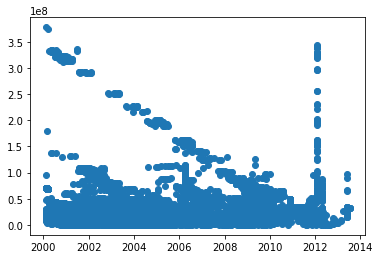

In [49]:
plt.scatter(test_df['event time:timestamp'] , abs(test_df['estimator']-test_df['time-to-end']))

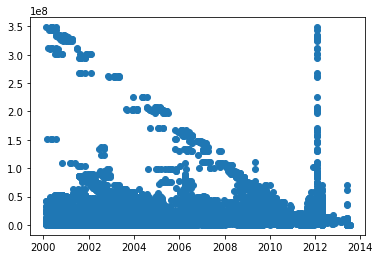

In [50]:
plt.scatter(test_df['event time:timestamp'] , abs(test_df['estimator2']-test_df['time-to-end']))

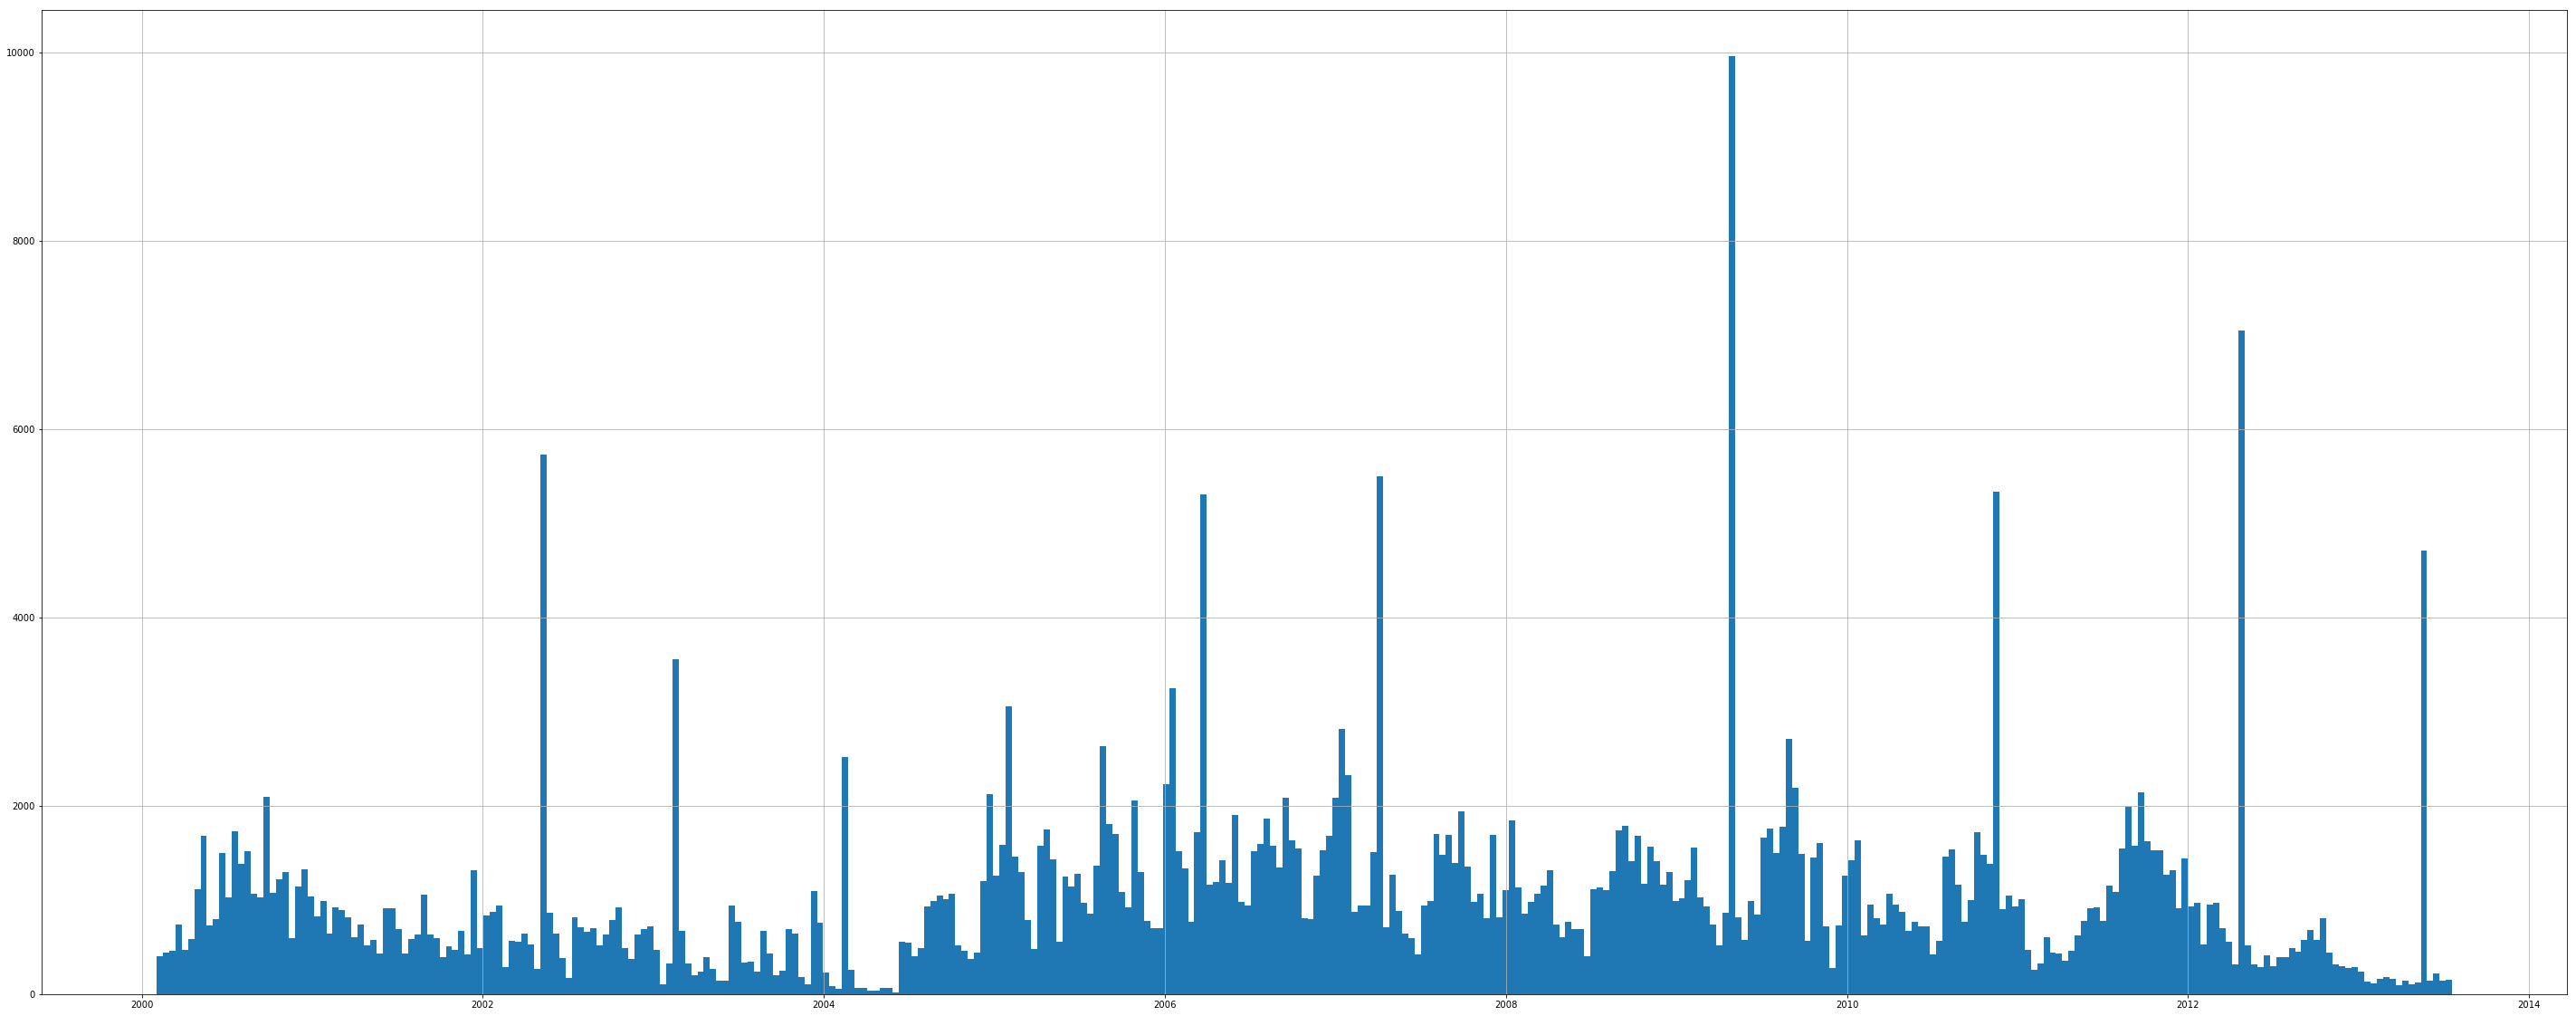

In [67]:
#train_df['event time:timestamp'] = train_df['event time:timestamp'].apply(lambda a : a.day)/365+train_df['event time:timestamp'].apply(lambda a : a.year)+train_df['event time:timestamp'].apply(lambda a : a.month)/12
train_df["event time:timestamp"].hist(bins=365, figsize=[50,20])

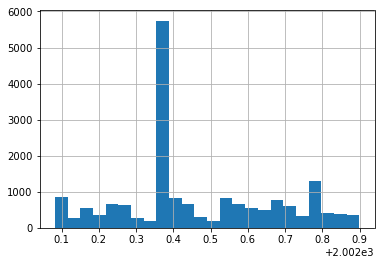

In [73]:
train_df[(train_df['event time:timestamp'] > 2002.08) & (train_df['event time:timestamp'] < 2002.9)]['event time:timestamp'].hist(bins=24)